In [1]:
import numpy as np

from astropy.io import fits
from astropy.table import Table

from matplotlib import pyplot as plt
%matplotlib inline

import emcee as mc

from scipy.special import gammaln
from scipy.stats import gaussian_kde

from time import time as timer

In [2]:
table = fits.open("kplr011904151-2010265121752_llc.fits")
tab = table[1]
data = Table(tab.data)

flux_orig = data['PDCSAP_FLUX'][:1325]
time_orig = data['TIME'][:1325]
ind_nan = [i for i in range(len(flux_orig)) if str(flux_orig[i]) == "nan"]
flux = [flux_orig[i] for i in range(len(flux_orig)) if i not in ind_nan]
time = [time_orig[i] for i in range(len(time_orig)) if i not in ind_nan]

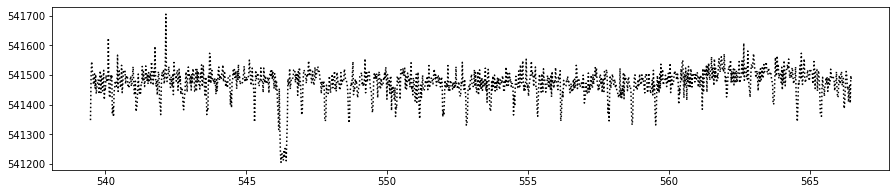

In [3]:
# plot useful data
plt.figure(figsize=(15,3))
plt.plot(time, flux, "k:")
plt.show()

In [4]:
def step(time, f, df, p, tt, tf, off=0):
    """
    Flux, from a uniform star source with single orbiting planet, as a function of time
    :param time: 1D array, input times
    :param f: unobstructed flux, max flux level
    :param df: ratio of obscured to unobscured flux
    :param p: period of planet's orbit
    :param tt: total time of transit
    :param tf: time during transit in which flux doesn't change
    :param off: time offset, a value of 0 means the transit begins immidiately
    :return: Flux from the star
    """
    y = []
    h = f*df*tt/(tt-tf)
    grad = 2*h/tt
    for i in time:
        j = (i + off) % p
        if j < tt:
            # transit
            if j/tt < 0.5:
                # first half of transit
                val = f - grad*j
                if val < f*(1 - df):
                    y.append(f*(1 - df))
                else:
                    y.append(val)
            else:
                # last half of transit
                val = (grad*j) - 2*h + f
                if val < f*(1 - df):
                    y.append(f*(1 - df))
                else:
                    y.append(val)
        else:
            # no transit
            y.append(f)
    return y

In [5]:
f_mu = 541500
f_sig = 100

df_mu = 2.2e-4
df_sig = 0.3e-4

p_mu = 0.84
p_sig = 0.05

tt_mu = 0.147
tt_sig = 0.05

tf_mu = 0.0882353
tf_sig = 0.005

off_mu = 0.0
off_sig = 0.005

priors = [(f_mu, f_sig), (df_mu, df_sig), (p_mu, p_sig),
          (tt_mu, tt_sig), (tf_mu, tf_sig), (off_mu, off_sig)]

In [6]:
def loglike(theta, obs, times):
    f_like, df_like, p_like, tt_like, tf_like, off_like = theta
    lmbda = np.array(step(times, f_like, df_like, p_like, tt_like, tf_like, off=off_like))
    n = len(obs)
    a = np.sum(gammaln(np.array(obs)+1))
    b = np.log(lmbda)*np.sum(obs)
    return -n*lmbda - a + b

In [7]:
def logprior(theta):
    lprior = 0
    for i in range(len(priors)):
        lprior -= 0.5*((theta[i] - priors[i][0]) / priors[i][1])**2
    return lprior

In [8]:
def logposterior(theta, obs, times):
    lprior = logprior(theta)
    if not np.isfinite(lprior):
        return -np.inf
    return lprior + loglike(theta, obs, times)

In [9]:
Nens = 100
inisamples = np.array([np.random.normal(priors[i][0], priors[i][1], Nens) for i in range(len(priors))]).T
ndims = inisamples.shape[1]

Nburn = 500
Nsamples = 500

loglike.ncalls = 0

In [10]:
sampler = mc.EnsembleSampler(Nens, ndims, logposterior, args=[flux, time])

t0 = timer()
sampler.run_mcmc(inisamples, Nsamples+Nburn)
t1 = timer()
print(t1-t0)

81.44952893257141


In [11]:
samples_emcee = sampler.chain[:, Nburn:, :].reshape((-1, ndims))

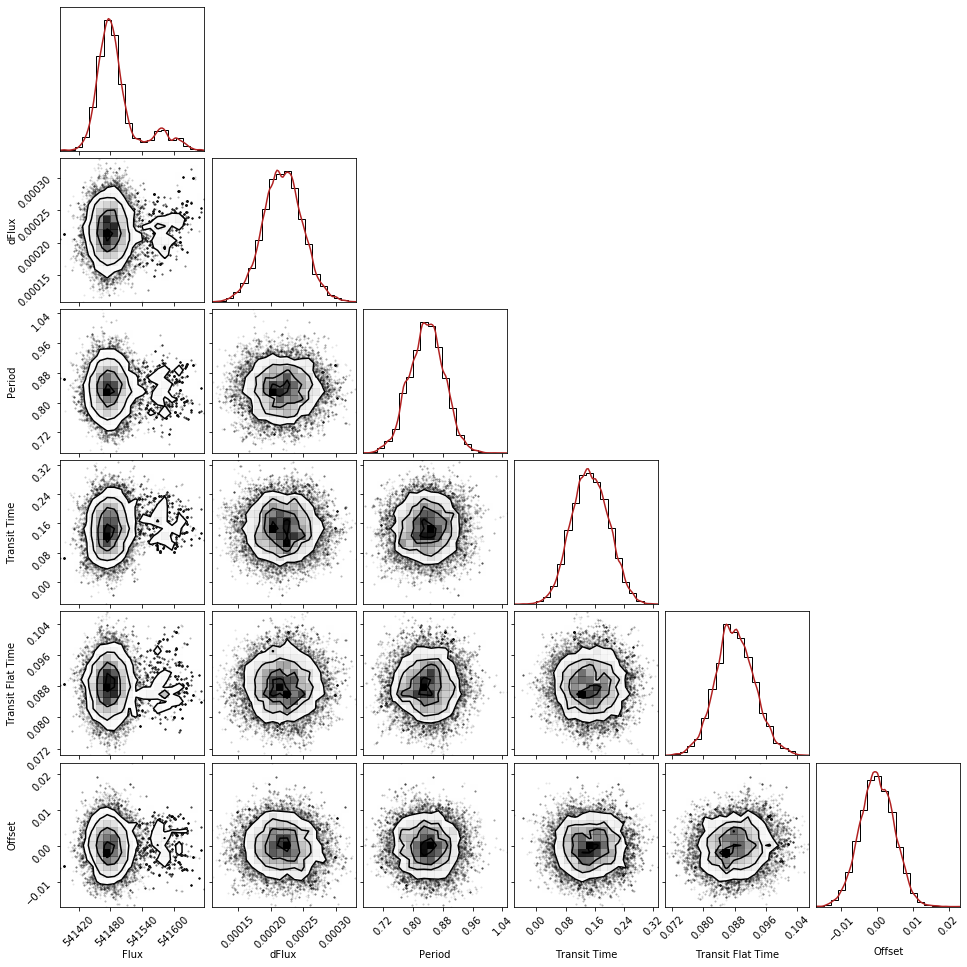

In [12]:
import corner
def plotposts(samples, labels, **kwargs):
    
    fig = corner.corner(samples, labels=labels, hist_kwargs={'density': True}, **kwargs)
    pos = [i*(len(labels)+1) for i in range(len(labels))]
    for axidx, samps in zip(pos, samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
        
labels = ['Flux', 'dFlux', 'Period', 'Transit Time', 'Transit Flat Time', 'Offset']
plotposts(samples_emcee, labels)

In [13]:
resdict = {}

resdict['f_mu'] = np.mean(samples_emcee[:,0])
resdict['f_sig'] = np.std(samples_emcee[:,0])
resdict['df_mu'] = np.mean(samples_emcee[:,1])
resdict['df_sig'] = np.std(samples_emcee[:,1])
resdict['p_mu'] = np.mean(samples_emcee[:,2])
resdict['p_sig'] = np.std(samples_emcee[:,2])
resdict['tt_mu'] = np.mean(samples_emcee[:,3])
resdict['tt_sig'] = np.std(samples_emcee[:,3])
resdict['tf_mu'] = np.mean(samples_emcee[:,4])
resdict['tf_sig'] = np.std(samples_emcee[:,4])
resdict['off_mu'] = np.mean(samples_emcee[:,5])
resdict['off_sig'] = np.std(samples_emcee[:,5])

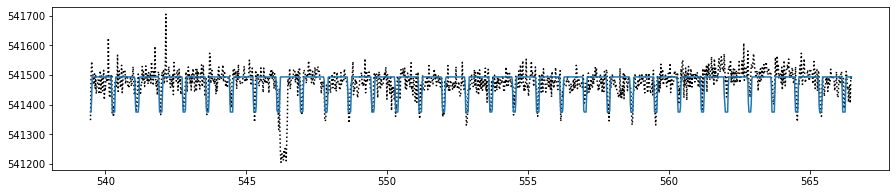

In [18]:
f, ferr = resdict['f_mu'], resdict['f_sig']
df, dferr = resdict['df_mu'], resdict['df_sig']
p, perr = resdict['p_mu'], resdict['p_sig']
tt, tterr = resdict['tt_mu'], resdict['tt_sig']
tf, tferr = resdict['tf_mu'], resdict['tf_sig']
off, offerr = resdict['off_mu'], resdict['off_sig']

plt.figure(figsize=(15,3))
plt.plot(time, flux, "k:")

x = np.linspace(min(time), max(time), 1313)
y = step(x, f, df, p, tt, tf, off)
plt.plot(time, y)
plt.show()

In [20]:
print("f = {} \u00B1 {} \n".format(f,ferr) + "df = {} \u00B1 {} \n".format(df,dferr) +
      "p = {} \u00B1 {} \n".format(p,perr) + "tt = {} \u00B1 {} \n".format(tt,tterr) +
      "tf = {} \u00B1 {} \n".format(tf,tferr) + "off = {} \u00B1 {} \n".format(off,offerr))

f = 541493.3641171309 ± 43.046761938216044 
df = 0.00021843227866273607 ± 3.0050333693494446e-05 
p = 0.8362506608135575 ± 0.04688355890223564 
tt = 0.14733034441369847 ± 0.05043247207912071 
tf = 0.08815546775077762 ± 0.004995607072072006 
off = -2.103449749165209e-05 ± 0.0048050131931093466 

